# Sistem Komunikasi Multimedia

## RGB to YUV Converter

#### Snippet code: RGB to YUV
The snippet code based on this [#Reference](https://stackoverflow.com/questions/43983265/rgb-to-yuv-conversion-and-accessing-y-u-and-v-channels)

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.image as mpimg

def load_img(img):
    return cv2.imread(img)

def rgb2yuv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

def split_channel(img):
    return cv2.split(img)

def write_xlsx(arr, path):
    return pd.DataFrame(arr).to_excel(path)

> Setup notebook:

In [2]:
np.set_printoptions(precision=4, suppress=True)
%matplotlib inline

#### Load source.jpg

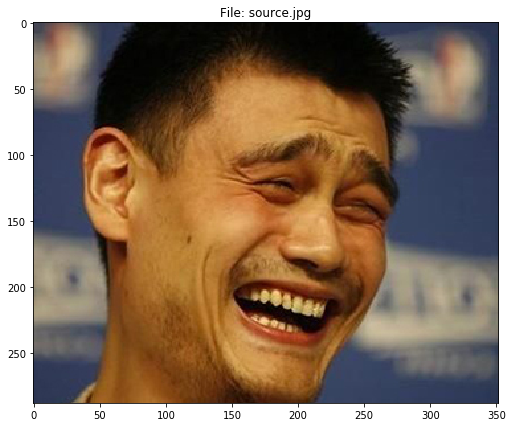

In [3]:
source = load_img("./input/source.jpg")

pylab.rcParams['figure.figsize'] = (20.0, 7)
plt.figure()
plt.title("File: source.jpg")
plt.imshow(mpimg.imread('./input/source.jpg'))

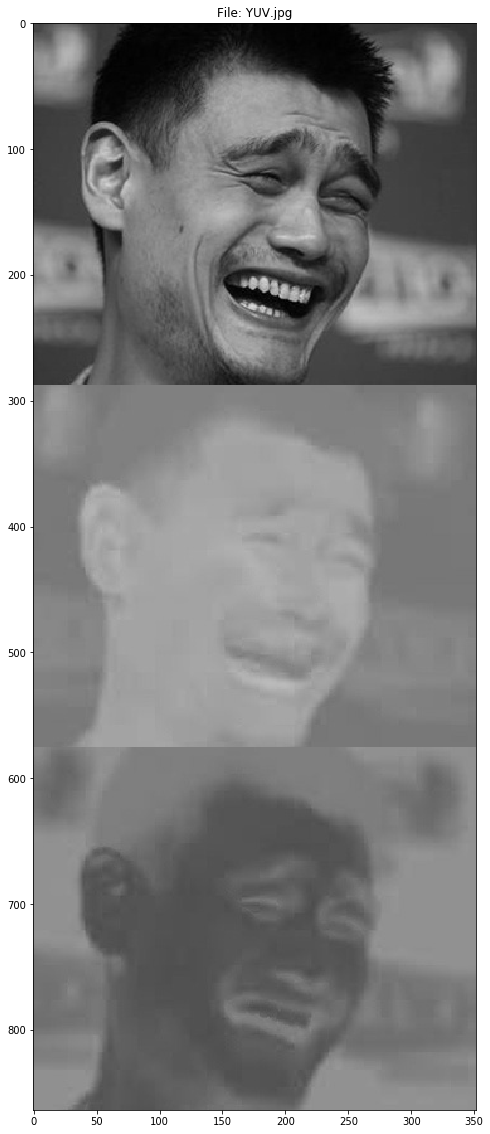

In [4]:
yuv = rgb2yuv(source)
y, u, v = split_channel(yuv)

# Write YUV to yuv.jpg and write matrix Y Channel to matrix_y.xlsx
cv2.imwrite("./output/YUV.jpg", np.vstack([y,u,v]))
write_xlsx(y, "./output/Y-channel.xlsx")

pylab.rcParams['figure.figsize'] = (20.0, 20.0)

plt.figure()
plt.title("File: YUV.jpg")
plt.imshow(load_img("./output/YUV.jpg"))

 - - - -
 - - - -

## Y to DCT

Based on this [#Reference](https://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html?highlight=inrange#dct) and this [#Reference](https://github.com/javiribera/jpeg-encoder/blob/master/main.py)

### #1 DCT from OpenCV using aproximate

Approximates a single channel image by using only the first coefficients of the DCT.
First, the image is chopped into 8x8 pixels patches and the DCT is applied to each patch.
Then, if num_coeffs is provided, only the first K DCT coefficients are kept.
If not, all the elements are quantized using the JPEG quantization matrix and the scale_factor.
Finally, the resulting coefficients are used to approximate the original patches with the IDCT, and the image is
reconstructed back again from these patches.

In [8]:
import itertools
import utils

def aproximate(img, num_coeffs=None, scale_factor=1):
    if not single_channel(img):
        raise ValueError('Input image must be a single channel 2D array')
    elif not shape_img(img):
        raise ValueError("Image dimensions must be multiple of 8")
    
    img_blocks = [
        img[col:col + 8, row:row + 8]
        for (col, row) in itertools.product(
            range(0, img.shape[0], 8),
            range(0, img.shape[1], 8)
        )
    ]
    
    # DCT transform every 8x8 block
    dct_blocks = [cv2.dct(img_block.astype(np.float32)) for img_block in img_blocks]
    
    if num_coeffs is not None:
        # keep only the first K DCT coefficients of every block
        reduced_dct_coeffs = [utils.zig_zag(dct_block, num_coeffs) for dct_block in dct_blocks]
    else:
        # quantize all the DCT coefficients using the quantization matrix and the scaling factor
        reduced_dct_coeffs = [
            np.round(dct_block / (utils.jpeg_quantiz_matrix * scale_factor))
            for dct_block in dct_blocks
        ]

        
    print(dct_blocks[0])
        
#     # IDCT of every block
#     rec_img_blocks = [cv2.idct(coeff_block) for coeff_block in reduced_dct_coeffs]

#     # reshape the reconstructed image blocks
#     rec_img = []
#     for chunk_row_blocks in utils.chunks(rec_img_blocks, img.shape[1] // 8):
#         for row_block_num in range(8):
#             for block in chunk_row_blocks:
#                 rec_img.extend(block[row_block_num])
#     rec_img = np.array(rec_img).reshape(img.shape[0], img.shape[2])

#     return rec_img
    
def single_channel(img):
    return (len(img.shape) == 2)

def shape_img(img):
    rows, cols = img.shape[0], img.shape[1]
    return ((rows % 8 == 0) or (cols % 8 == 0))

aproximate(y)

[[578.25    -5.7037   5.8631  -4.1937   3.      -1.3762   1.0892  -2.0885]
 [ -2.7405   7.8405  -2.4741   0.0165  -0.9549  -0.011   -1.1347   0.0176]
 [ -0.7325  -1.0167   1.9053   0.7206  -0.7886   0.908    0.125    0.4353]
 [  0.0138   1.1819  -1.5737  -0.0794   0.1793  -0.0591  -0.1087  -0.2351]
 [  1.25    -0.7496   1.0196   1.4757   0.      -0.3154  -0.1517   0.1895]
 [  0.1338   1.0154  -1.2142  -0.1323  -0.0047   0.0135  -0.14    -0.202 ]
 [  0.8446  -1.1147  -0.125    0.542    0.056    0.2134   0.8447   0.3182]
 [ -1.1605   0.4444   0.3119   0.3949   0.4254  -0.2639   0.1073   0.2253]]


#### DCT from Y Channel Matrix:
[Download](./files/output/matrix_DCTfromY.xlsx?download=1)


 - - - -

### #2 DCT from manual
Based on this [#Reference](https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html)

#### Define 2D DCT and IDCT

In [ ]:
import scipy
from scipy.fftpack import dct, idct
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_


def dct2(v):
    return scipy.fftpack.dct(scipy.fftpack.dct(v, axis=0, norm='ortho' ), axis=1, norm='ortho')

def idct2(v):
    return scipy.fftpack.idct(scipy.fftpack.idct(v, axis=0 , norm='ortho'), axis=1 , norm='ortho')

#### Perform a blockwise DCT

In [ ]:
## source = bgr2rgb(source)
imsize = source.shape
dct = np.zeros(imsize)

# Do 8x8 DCT on image (in-place)
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        dct[i:(i+8),j:(j+8)] = dct2(source[i:(i+8),j:(j+8)] )

cv2.imwrite("./output/dct.jpg", dct)